This page was created from a Jupyter notebook. The original notebook can be found [here](https://github.com/klane/databall/blob/master/notebooks/parameter-tuning.ipynb). It investigates tuning model parameters to achieve better performance. First we must import the necessary installed modules.

In [1]:
import itertools
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from hyperopt import hp, fmin, tpe, Trials, space_eval

In [2]:
import os
import sys
import warnings

warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from databall.database import Database
from databall.plotting import format_538, plot_metrics, plot_matrix
from databall.model_selection import calculate_metrics, optimize_params, train_test_split
import databall.util as util

In [3]:
plt.style.use('fivethirtyeight')

# Data

In [4]:
database = Database('../data/nba.db')
games = database.betting_stats(window=10)

In [5]:
x_train, y_train, x_test, y_test = train_test_split(games, 2016, xlabels=util.stat_names() + ['SEASON'])

In [6]:
stats = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK']
stats = ['TEAM_' + s for s in stats] + ['TEAM_OFF_RTG', 'TEAM_DEF_RTG']
stats += [s + '_AWAY' for s in stats] + ['HOME_SPREAD']

# Logistic Regression

The plots below show `LogisticRegression` model performance using different combinations of three parameters: `penalty` (type of norm), `class_weight` (where "balanced" indicates weights are inversely proportional to class frequencies and the default is one), and `dual` (flag to use the dual formulation). For each combination, models were trained with different `C` values, which controls the inverse of the regularization strength.

All models have similar accuracy, ROC area, and precision/recall area up to a `C` value of about 3, at which point the models using the dual formulation have degraded performance. Setting `class_weight` to "balanced" raises model precision slightly in most cases, but dramatically reduces recall. None of the models perform noticeably better than the default `LogisticRegression` model.

In [ ]:
# Create functions that return logistic regression models with different parameters
models = [partial(LogisticRegression, penalty='l1'),
          partial(LogisticRegression, penalty='l1', class_weight='balanced'),
          partial(LogisticRegression),
          partial(LogisticRegression, class_weight='balanced'),
          partial(LogisticRegression, dual=True),
          partial(LogisticRegression, class_weight='balanced', dual=True)]

start = -5
stop = 3
C_vec = np.logspace(start=start, stop=stop, num=4)
results = calculate_metrics(models, x_train, y_train, stats, 'C', C_vec, k=4)
legend = ['L1 Norm', 'L1 Norm, Balanced Class', 'L2 Norm (Default)',
          'L2 Norm, Balanced Class', 'L2 Norm, Dual Form', 'L2 Norm, Balanced Class, Dual Form']

fig, ax = plot_metrics(C_vec, results, 'Regularization Parameter', log=True)

ax[-1].legend(legend, fontsize=16, bbox_to_anchor=(1.05, 1), borderaxespad=0)
[a.set_xlim(10**start-10, 10**stop+10) for a in ax]
[a.set_ylim(-0.05, 1.05) for a in ax]
title = 'Bad teams lose at home more often'
subtitle = 'Kernel density estimations of home and away team SRS for home team wins and losses'
format_538(fig, 'NBA Stats & Covers.com', ax=ax, title=title, subtitle=subtitle, xoff=(-0.22, 3.45),
           yoff=(-1.54, -1.64), toff=(-.16, 1.25), soff=(-0.16, 1.12), n=100)
plt.show()

In [60]:
space = {}
space['C'] = hp.loguniform('C', -9*np.log(10), 3*np.log(10))
space['penalty'] = hp.choice('penalty', ['l1', 'l2'])
space['class_weight'] = hp.choice('class_weight', [None, 'balanced'])
model = LogisticRegression()
best, param_df = optimize_params(model, x_train, y_train, stats, space, max_evals=50)

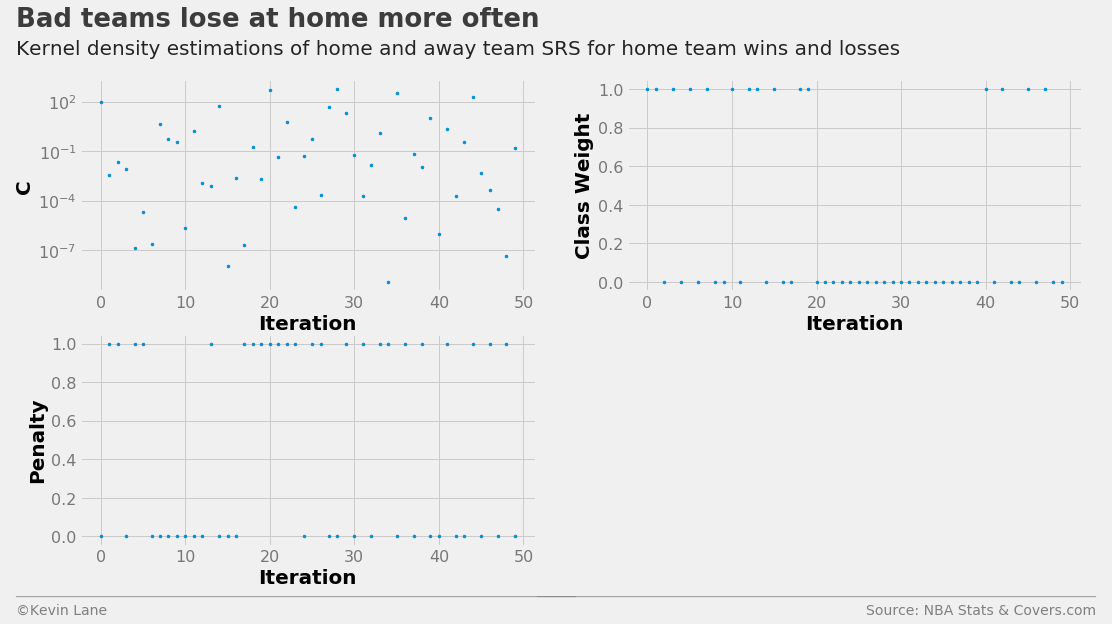

In [62]:
fig, ax = plot_matrix(param_df.index.values, param_df[['C', 'class_weight', 'penalty']].values,
                      'Iteration', ['C', 'Class Weight', 'Penalty'], 2, 2, logy=[True, False, False])

title = 'Bad teams lose at home more often'
subtitle = 'Kernel density estimations of home and away team SRS for home team wins and losses'
format_538(fig, 'NBA Stats & Covers.com', ax=ax, title=title, subtitle=subtitle, xoff=(-0.16, 2.25),
           yoff=(-1.42, -1.52), toff=(-.14, 1.25), soff=(-0.14, 1.12), n=80,
           bottomtick=np.nan)
plt.show()

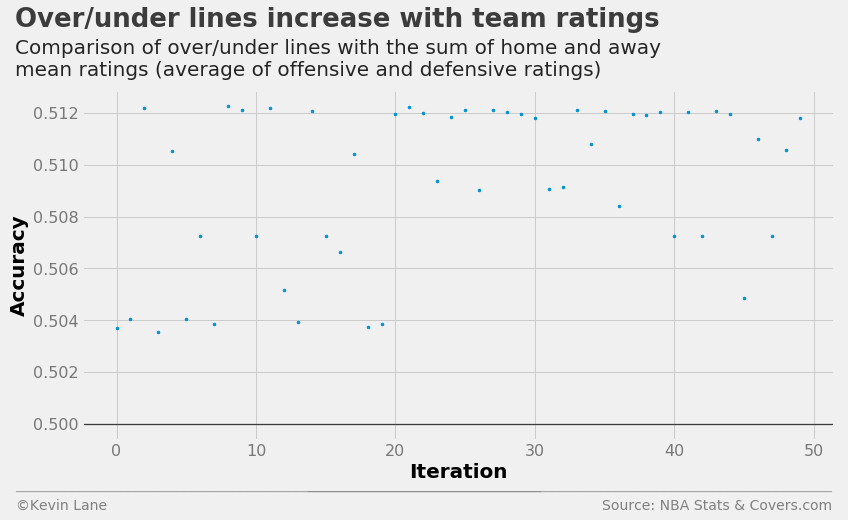

In [65]:
fig = plt.figure(figsize=(12, 6))
plt.plot(param_df.index.values, param_df['accuracy'], '.', markersize=5)

title = 'Over/under lines increase with team ratings'
subtitle = '''Comparison of over/under lines with the sum of home and away
mean ratings (average of offensive and defensive ratings)'''
format_538(fig, 'NBA Stats & Covers.com', xlabel='Iteration', ylabel='Accuracy',
           title=title, subtitle=subtitle, xoff=(-0.1, 1.01), yoff=(-0.14, -0.2),
           toff=(-0.09, 1.18), soff=(-0.09, 1.04), bottomtick=0.5)
plt.show()

# Support Vector Machine

The [`LinearSVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) class is similar to a generic [`SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with a linear kernel, but is implemented with liblinear instead of libsvm. The documentation states that `LinearSVC` scales better to large sample sizes since `SVC`'s fit time complexity is more than quadratic with the number of samples. I initially tried `SVC`, but the training time was too costly. `LinearSVC` proved to be must faster for this problem.

The plots below show `LinearSVC` model performance using different combinations of four parameters: `penalty` (identical to `LogisticRegression`), `loss` (the loss function), `class_weight` (identical to `LogisticRegression`), and `dual` (identical to `LogisticRegression`). For each combination, models were trained with different `C` values, which controls the penalty of the error term.

Similar to above, all models have similar accuracy, ROC area, and precision/recall area up to a `C` value of about 10, at which point the models using the dual formulation have degraded performance. Again, setting `class_weight` to "balanced" raises model precision slightly in most cases, but dramatically reduces recall. None of the models perform noticeably better than the default `LinearSVC` model.

In [ ]:
space = {}
space['C'] = hp.loguniform('C', -9*np.log(10), 3*np.log(10))
space['penalty'] = hp.choice('penalty', ['l1', 'l2'])
space['loss'] = hp.choice('loss', ['hinge', 'squared_hinge'])
space['dual'] = hp.choice('dual', [True, False])
space['class_weight'] = hp.choice('class_weight', [None, 'balanced'])
model = LinearSVC()
best, param_df = optimize_params(model, x_train, y_train, stats, space, max_evals=50)

In [ ]:
fig, ax = plot_matrix(param_df.index.values, param_df[['C', 'class_weight', 'penalty']].values,
                      'Iteration', ['C', 'Class Weight', 'Penalty'], 2, 2, logy=[True, False, False])

title = 'Bad teams lose at home more often'
subtitle = 'Kernel density estimations of home and away team SRS for home team wins and losses'
format_538(fig, 'NBA Stats & Covers.com', ax=ax, title=title, subtitle=subtitle, xoff=(-0.16, 2.25),
           yoff=(-1.42, -1.52), toff=(-.14, 1.25), soff=(-0.14, 1.12), n=80,
           bottomtick=np.nan)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(param_df.index.values, param_df['accuracy'], '.', markersize=5)

title = 'Over/under lines increase with team ratings'
subtitle = '''Comparison of over/under lines with the sum of home and away
mean ratings (average of offensive and defensive ratings)'''
format_538(fig, 'NBA Stats & Covers.com', xlabel='Iteration', ylabel='Accuracy',
           title=title, subtitle=subtitle, xoff=(-0.1, 1.01), yoff=(-0.14, -0.2),
           toff=(-0.09, 1.18), soff=(-0.09, 1.04), bottomtick=0.5)
plt.show()

# Random Forest

The plots below show [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) model performance using different combinations of the parameters `class_weight` (identical to `LogisticRegression`) and `criterion` (function to evaluate split quality). For each combination, models were trained with different `n_estimators`, which controls the number of decision trees in the forest. Neither `criterion` nor `class_weight` have much impact on model performance. Performance improves with increased `n_estimators`, but performance quickly asymptotes at about 10 trees. None of the models perform noticeably better than the default `RandomForestClassifier` model.

In [ ]:
space = {}
space['n_estimators'] = 10 + hp.randint('n_estimators', 90)
space['criterion'] = hp.choice('criterion', ['gini', 'entropy'])
space['bootstrap'] = hp.choice('bootstrap', [True, False])
space['class_weight'] = hp.choice('class_weight', [None, 'balanced'])
model = RandomForestClassifier(random_state=8)
best, param_df = optimize_params(model, x_train, y_train, stats, space, max_evals=50)

In [ ]:
fig, ax = plot_matrix(param_df.index.values, param_df[[k for k in space.keys()]].values,
                      'Iteration', ['Estimators', 'Criterion', 'Bootstrap'],
                      2, 2)

title = 'Bad teams lose at home more often'
subtitle = 'Kernel density estimations of home and away team SRS for home team wins and losses'
format_538(fig, 'NBA Stats & Covers.com', ax=ax, title=title, subtitle=subtitle, xoff=(-0.16, 2.25),
           yoff=(-1.42, -1.52), toff=(-.14, 1.25), soff=(-0.14, 1.12), n=80,
           bottomtick=np.nan)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(param_df.index.values, param_df['accuracy'], '.', markersize=5)

title = 'Over/under lines increase with team ratings'
subtitle = '''Comparison of over/under lines with the sum of home and away
mean ratings (average of offensive and defensive ratings)'''
format_538(fig, 'NBA Stats & Covers.com', xlabel='Iteration', ylabel='Accuracy',
           title=title, subtitle=subtitle, xoff=(-0.1, 1.01), yoff=(-0.14, -0.2),
           toff=(-0.09, 1.18), soff=(-0.09, 1.04), bottomtick=0.5)
plt.show()

# Neural Network

The plots below show [`MLPClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) model performance using different combinations of the parameters `hidden_layer_sizes` (number of neurons in each hidden layer) and `activation` (network activation function). For each combination, models were trained with different `alpha` values, which controls the L2 regularization similar to `LogisticRegression` and `LinearSVC`. All models have nearly identical performance until higher regularization strength. At high values of `alpha`, recall dramatically improves, but the other four metrics all worsen. None of the models perform noticeably better than the default `MLPClassifier` model.

In [ ]:
space = {}
space['hidden_layer_sizes'] = 10 + hp.randint('hidden_layer_sizes', 90)
space['alpha'] = hp.loguniform('alpha', -9*np.log(10), 3*np.log(10))
space['activation'] = hp.choice('activation', ['relu', 'logistic'])
model = RandomForestClassifier(random_state=8)
best, param_df = optimize_params(model, x_train, y_train, stats, space, max_evals=50)

In [ ]:
fig, ax = plot_matrix(param_df.index.values, param_df[[k for k in space.keys()]].values,
                      'Iteration', ['Estimators', 'Criterion', 'Bootstrap'],
                      2, 2)

title = 'Bad teams lose at home more often'
subtitle = 'Kernel density estimations of home and away team SRS for home team wins and losses'
format_538(fig, 'NBA Stats & Covers.com', ax=ax, title=title, subtitle=subtitle, xoff=(-0.16, 2.25),
           yoff=(-1.42, -1.52), toff=(-.14, 1.25), soff=(-0.14, 1.12), n=80,
           bottomtick=np.nan)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(param_df.index.values, param_df['accuracy'], '.', markersize=5)

title = 'Over/under lines increase with team ratings'
subtitle = '''Comparison of over/under lines with the sum of home and away
mean ratings (average of offensive and defensive ratings)'''
format_538(fig, 'NBA Stats & Covers.com', xlabel='Iteration', ylabel='Accuracy',
           title=title, subtitle=subtitle, xoff=(-0.1, 1.01), yoff=(-0.14, -0.2),
           toff=(-0.09, 1.18), soff=(-0.09, 1.04), bottomtick=0.5)
plt.show()

In [ ]:
# space['clf__l1_ratio'] = hp.uniform('clf__l1_ratio', 0.0, 1.0)
# space['clf__alpha'] = hp.loguniform('clf__alpha', -9*np.log(10), -4*np.log(10))
# space['clf__n_iter'] = 20 + 5*hp.randint('clf__n_iter', 12)